In [2]:
import pandas as pd

from model import init_utils
from model import processing
# Experiments
from model import run
from model.plot_utils import *

########## AGENT CONFIGURATION ##########
# key -> token name, value -> token amount owned by agent
# note that token name of 'omniABC' is used for omnipool LP shares of token 'ABC'
# omniHDXABC is HDX shares dedicated to pool of token ABC

trader = {'HDX': 1000000, 'R1': 1000000, 'R2': 1000000}

# key -> agent_id, value -> agent dict
agent_d = {'Trader': trader}

########## ACTION CONFIGURATION ##########

action_dict = {
    'sell_r2_for_r1': {'token_buy': 'R1', 'token_sell': 'R2', 'amount_sell': 5000, 'action_id': 'Trade',
                       'agent_id': 'Trader'},
    'sell_r1_for_r2': {'token_sell': 'R1', 'token_buy': 'R2', 'amount_sell': 1000, 'action_id': 'Trade',
                       'agent_id': 'Trader'}
}

# list of (action, number of repetitions of action), timesteps = sum of repititions of all actions
trade_count = 1
action_ls = [('trade', trade_count)]

# maps action_id to action dict, with some probability to enable randomness
prob_dict = {
    'trade': {'sell_r2_for_r1': 0.0,
              'sell_r1_for_r2': 1.0}
}

########## CFMM INITIALIZATION ##########

initial_values = {
    'token_list': ['R1', 'R2'],
    'R': [500000, 1500000],
    'P': [2, 2 / 3],
    'fee_assets': 0.0015,
    'fee_HDX': 0.0015
}

############################################ SETUP ##########################################################

config_params = {
    'cfmm_type': "",
    'initial_values': initial_values,
    'agent_d': agent_d,
    'action_ls': action_ls,
    'prob_dict': prob_dict,
    'action_dict': action_dict,
}

config_dict, state = init_utils.get_configuration(config_params)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()

rdf, agent_df = processing.postprocessing(events)

print(agent_df.tail(20))




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Is this trade type sell called?
Is this trade type sell called?
Total execution time: 0.01s
   simulation  subset  run  substep  timestep agent_label          q  s-0  \
3           0       0    1        3         1      Trader 1000000.00    0   

   s-1     r-0        r-1  p-0  p-1  
3    0  999000 1002979.10    0    0  


In [3]:
agent_df.head()

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
3,0,0,1,3,1,Trader,1000000.00,0,0,999000,1002979.10,0,0


In [4]:
rdf.head()

,R-0,R-1,Q-0,Q-1,S-0,S-1,A-0,A-1,B-0,B-1,...,token_list-0,token_list-1,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
0,500000,1500000.00,1000000.00,1000000.00,500000,1500000,0,0,500000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,0,0
3,501000,1497020.90,998003.99,1001996.01,500000,1500000,0,0,500000,1500000,...,R1,R2,0.00,0.00,2,0,0,1,3,1


In [5]:
pd.DataFrame(events)

,external,AMM,uni_agents,simulation,subset,run,substep,timestep
0,{},"{'R': [500000, 1500000], 'Q': [1000000, 100000...","{'Trader': {'q': 1000000, 's': [0, 0], 'r': [1...",0,0,1,0,0
1,{},"{'R': [500000, 1500000], 'Q': [1000000, 100000...","{'Trader': {'q': 1000000, 's': [0, 0], 'r': [1...",0,0,1,1,1
2,{},"{'R': [501000, 1497020.9007098628], 'Q': [9980...","{'Trader': {'q': 1000000.0, 's': [0, 0], 'r': ...",0,0,1,2,1
3,{},"{'R': [501000, 1497020.9007098628], 'Q': [9980...","{'Trader': {'q': 1000000.0, 's': [0, 0], 'r': ...",0,0,1,3,1


[0]


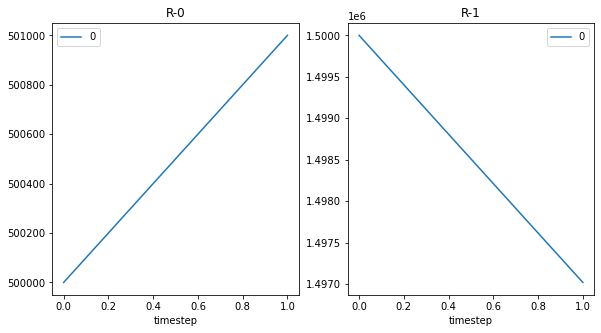

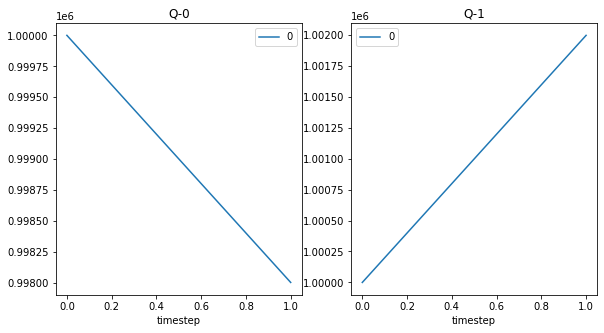

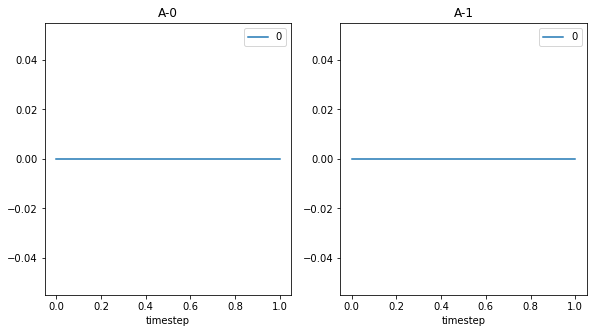

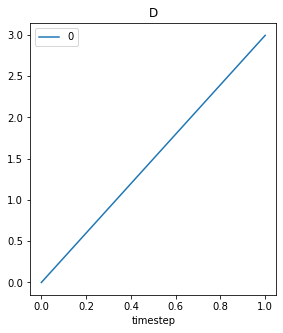

In [6]:

var_list = ['R', 'Q', 'A', 'D']
plot_vars(rdf, var_list)

Asset $i$ is sold for asset $j$ in a series of trades, with 
$$
\Delta Q_i = Q_i\frac{- \Delta R_i}{R_i + \Delta R_i}\\
\Delta Q_j = -\Delta Q_i (1 - f_P)\\
\Delta R_j = R_j\frac{- \Delta Q_j}{Q_j + \Delta Q_j}(1 - f_A)
$$

In [7]:
delta_qi = rdf['Q-0'][0] * (-action_dict['sell_r1_for_r2']['amount_sell'])/(rdf['R-0'][0]+action_dict['sell_r1_for_r2']['amount_sell'])
delta_qi

-1996.007984031936

In [8]:
rdf['Q-0'][3] == delta_qi + rdf['Q-0'][0]

True

In [9]:
delta_qj = -delta_qi*(1-initial_values['fee_HDX'])
delta_qj

1993.0139720558882

In [10]:
rdf['Q-1'][3] == delta_qj + rdf['Q-1'][0]

False

In [11]:
rdf['Q-1'][3] - rdf['Q-1'][0]

1996.0094511709176

In [12]:
delta_rj = rdf['R-1'][0]*(-delta_qj*(1-initial_values['fee_assets']))/(rdf['Q-1'][0]+delta_qj)
delta_rj

-2979.0992901373215

In [13]:
rdf['R-1'][3] == delta_rj + rdf['R-1'][0]

False

In [14]:
rdf['R-1'][3] - rdf['R-1'][0]

-2979.099290137179

The LHDX fee is added to treasury
$$
\Delta D = -\Delta Q_i f_P
$$

We add the asset fee back to the $j$ pool, and mint LHDX so that the asset fee does not change the price of asset $j$
$$
R_j^+ = R_j + \Delta R_j - f_A \Delta R_j\\
Q_j^+ = R_j^+ \frac{Q_jR_j}{(R_j + \Delta R_j)^2}
$$

In [15]:
# right side of Rj+
rdf['R-1'][0] + delta_rj *(1- initial_values['fee_assets'])

1497025.3693587978

In [16]:
# cadcad Rj+
rdf['R-1'][3]

1497020.9007098628

In [17]:
# verification check
rdf['R-1'][3] == rdf['R-1'][0] + delta_rj *(1- initial_values['fee_assets'])

False

In [18]:
# Qj+ right side
new_Q_1 = rdf['R-1'][3] * rdf['R-1'][0] * rdf['Q-1'][0] / ( rdf['R-1'][0]+delta_rj)**2
new_Q_1

1001990.018501896

In [19]:
# cadcad Rj+
rdf['Q-1'][3]

1001996.0094511709

In [20]:
# Qj+ using Rj+ computed from right side of Rj+ equation 
new_Q_1_from_right = (rdf['R-1'][0] + delta_rj *(1- initial_values['fee_assets'])) * rdf['R-1'][0] * rdf['Q-1'][0] / ( rdf['R-1'][0]+delta_rj)**2
new_Q_1_from_right

1001993.0094699091